<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/inverseProblems/cnnDemosaicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Demosaicing
## David Brady
## University of Arizona

This notebook implements a demosaicing neural network using the Kodak photo CD data set and compares the results with bilinear demosaicing.
.

### Load modules

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu, elu, sigmoid, swish, relu
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.special import expit
from google.colab import files
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import imageio
from PIL import Image
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
tf.experimental_relax_shapes=True

### Activation functions

Activation functions are central to the operation of neural networks. Although the sigmoid activation is intuitively attractive, it's derivatives are zero over most of its range and thus it is difficult to use in gradient descent optimization. The Relu function has been found to have better training properties. relu also has a null gradient for negative inputs, various alternatives with continuous derivatives are also plotted below.

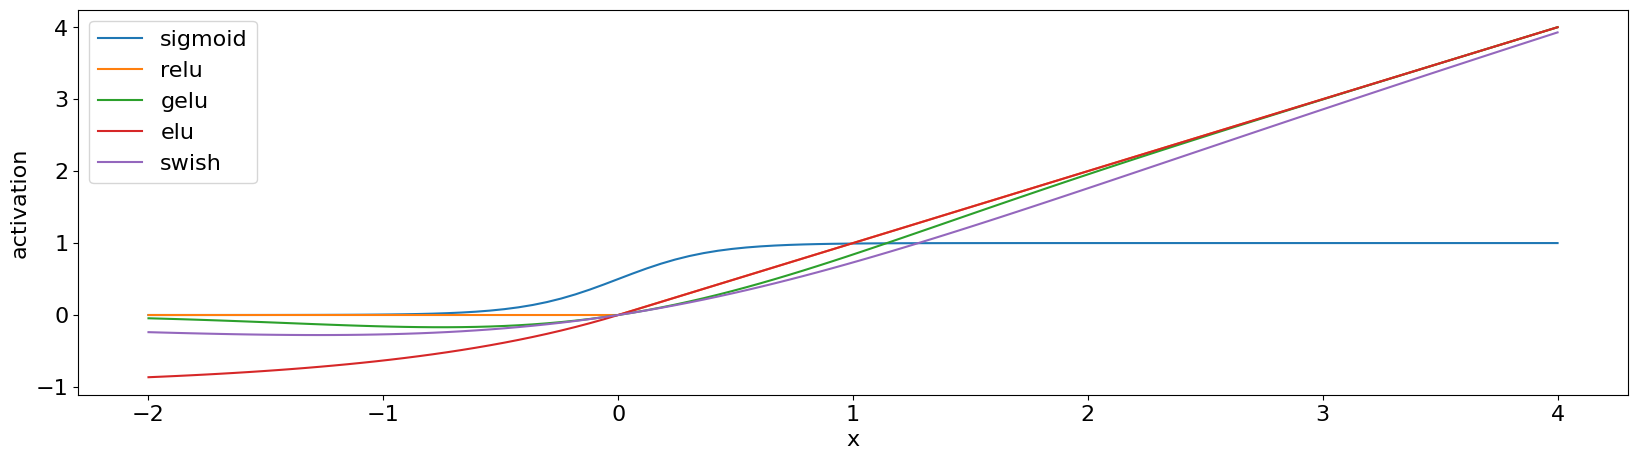

In [ ]:
#
# relu, sigmoid and softmax optimization functions
#
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams.update({'font.size': 16})
x=np.linspace(-2,4,100)
plt.plot(x,sigmoid(5*x),label='sigmoid')
plt.plot(x,relu(x),label='relu')
plt.plot(x,gelu(x),label='gelu')
plt.plot(x,elu(x),label='elu')
plt.plot(x,swish(x),label='swish')
plt.xlabel('x')
plt.ylabel('activation')
plt.legend()
plt.savefig('activation.pdf')
#files.download('activation.pdf')

In [3]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 10.2 MB/s eta 0:00:00


### Bayer image example

In [ ]:
!pip install rawpy
import rawpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.5 MB/s eta 0:00:00


In [ ]:
!wget --no-check-certificate --content-disposition 'https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/rawColor.dng'


--2023-08-29 15:39:15--  https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/rawColor.dng
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/rawColor.dng [following]
--2023-08-29 15:39:15--  https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/rawColor.dng
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24141248 (23M) [application/octet-stream]
Saving to: ‘rawColor.dng’

rawColor.dng        100%[===================>]  23.02M  --.-KB/s    in 0.07s  

In [ ]:
raw = rawpy.imread('rawColor.dng')
rawImage=raw.raw_image_visible

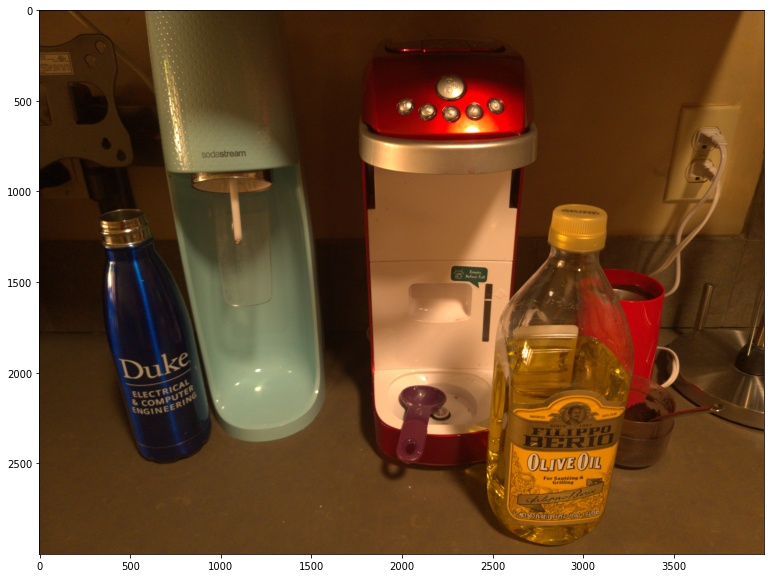

In [ ]:
plt.imshow(raw.postprocess())
#plt.axis('off')
#plt.savefig('colorExample.pdf')
#files.download('colorExample.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

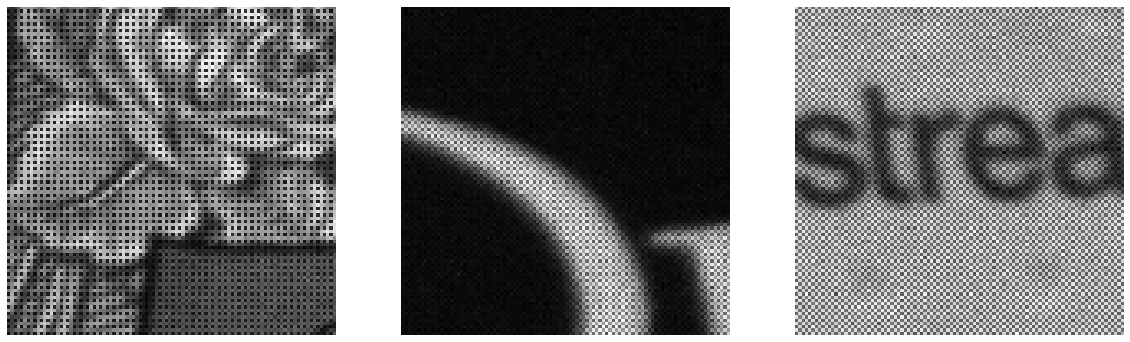

In [ ]:
plt.gray()
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,3,1)
plt.imshow(rawImage[2600:2700,2600:2700])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(rawImage[1900:2000,500:600])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(rawImage[750:850,1000:1100])
plt.axis('off')
plt.savefig('bayerPattern.pdf')
files.download('bayerPattern.pdf')

we can recover the rgb image by demosaicing. OpenCV implements bilinear interpolation to demosaic.

In [ ]:
colorI=cv2.cvtColor(rawImage, cv2.COLOR_BayerGR2BGR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


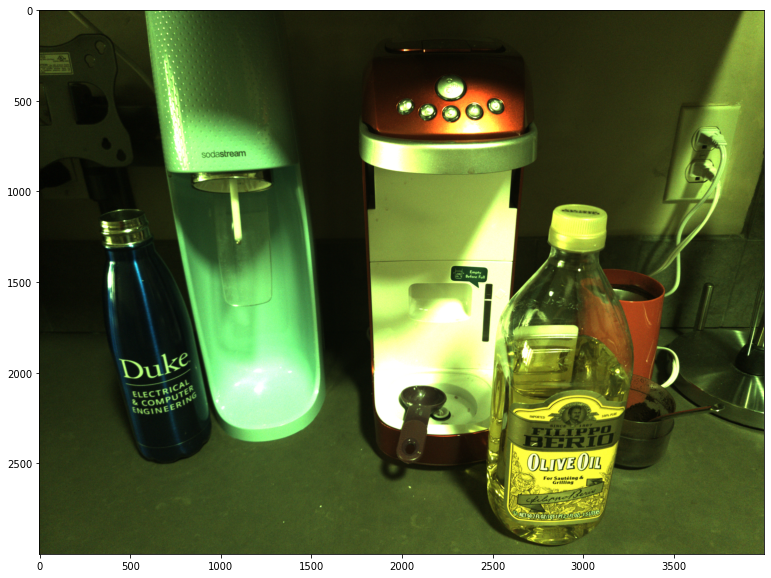

In [ ]:
plt.imshow(colorI)

# Demosaicing with neural processing

### Training data set

We use the Kodak photo cd data set, which was digitized from film as raw so


1.   it consists of raw rgb images and
2.   it was never sampled using a CFA

Not really prefect, but should be ok. There are 24 images, but we break them into sub images of size 64 by 64 to obtain a suitable set for training

The 24 image kodak data set is available as png images at https://www.kaggle.com/datasets/sherylmehta/kodak-dataset?select=kodim24.png


In [2]:
im=np.zeros((24,512,768,3))
for pop in range(1,10):
  fileN="kodim0"+str(pop)+".png"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h,c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.
for pop in range(10,25):
  fileN="kodim"+str(pop)+".png"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h, c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.

(-0.5, 767.5, 511.5, -0.5)

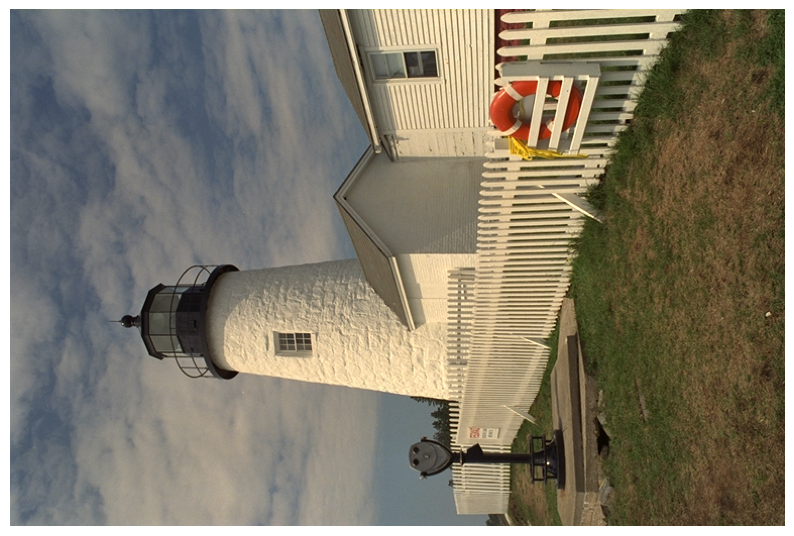

In [ ]:
plt.imshow(im[18,:,:,:])
plt.axis('off')

### Color sampling functions

In [3]:

#This is the filter array for Bayer color sampling
def bayerCFA(shape,dtype='none'):
    kernel = np.array([[[1,0,0],[0,0,0]],[[0,0,0],[0,0,0]]])
    kernel = np.stack((kernel,np.array([[[0,0,0],[0,1,0]],[[0,0,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,1,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,0,0],[0,0,1]]] )),axis=-1)
    return kernel

In [4]:
# This network transforms a 32 by 32 color image into a 16 by 16 by 4 bayer sample array
inputs = layers.Input(shape=(None,None,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA, trainable=False)(inputs)
cfaSample=Model(inputs,cfa)


In [5]:
def rgb2bayerGR2(image):
  w,h, c=image.shape
  bayer=np.zeros((w,h))
  bayer[0:w:2,0:h:2]=image[0:w:2,0:h:2,1]
  bayer[1:w:2,1:h:2]=image[1:w:2,1:h:2,1]
  bayer[0:w:2,1:h:2]=image[0:w:2,1:h:2,0]
  bayer[1:w:2,0:h:2]=image[1:w:2,0:h:2,2]
  bayer=255*bayer/np.max(bayer)
  bayer=bayer.astype('uint8')
  return bayer

In [8]:
dog=cfaSample.predict(im[4:5,:,:,:])


1/1 [==============================] - 7s 7s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

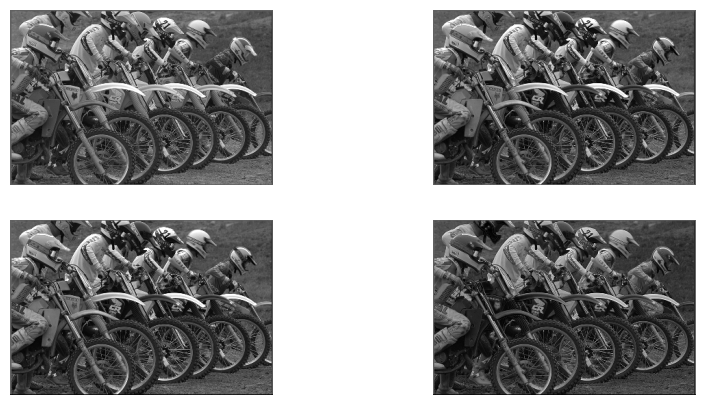

In [12]:

plt.rcParams['figure.figsize'] = [10, 5]
plt.gray()
plt.subplot(2,2,1)
plt.imshow(dog[0,:,:,0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(dog[0,:,:,1])
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(dog[0,:,:,2])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(dog[0,:,:,3])
plt.axis('off')
plt.savefig('motorbikeStack.pdf')
files.download('motorbikeStack.pdf')

### creation of training blocks

each image consists of 4 by 6=24 128 by 128 blocks. We use the first 20 images to generate 480 training images and the last 4 images to generate 96 test images

In [13]:
trainS=480
testS=96
xtrain=np.zeros((trainS,64,64,4))
ytrain=np.zeros((trainS,128,128,3))
xtest=np.zeros((testS,64,64,4))
ytest=np.zeros((testS,128,128,3))
for imc in range(20):
  for row in range(4):
    for column in range(6):
      ytrain[(imc*24+row*6+column),:,:,:]=im[imc,(row*128):((row+1)*128),(column*128):((column+1)*128),:]
      xtrain[(imc*24+row*6+column),:,:,:]=cfaSample.predict(im[imc:(imc+1),(row*128):((row+1)*128),(column*128):((column+1)*128),:])
for imc in range(4):
  for row in range(4):
    for column in range(6):
      ytest[(imc*24+row*6+column),:,:,:]=im[imc+20,(row*128):((row+1)*128),(column*128):((column+1)*128),:]
      xtest[(imc*24+row*6+column),:,:,:]=cfaSample.predict(im[(imc+20):(imc+21),(row*128):((row+1)*128),(column*128):((column+1)*128),:])
xtrain=np.reshape(xtrain, (len(xtrain), 64, 64, 4))
ytrain=np.reshape(ytrain, (len(ytrain), 128, 128, 3))
xtest=np.reshape(xtest, (len(xtest), 64, 64, 4))
ytest=np.reshape(ytest, (len(ytest), 128, 128, 3))
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest,ytest))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

1/1 [==============================] - 0s 19ms/step


## Network architecture

#### autoencoder with residuals

In [14]:
inputs = layers.Input(shape=(None,None,4))
# Encoder
x1 = layers.Conv2D(16, (2, 2), strides=2, activation="gelu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2))(x1)
x2 = layers.Conv2D(16, (3, 3), activation="gelu", padding="same")(x)
x3 = layers.Conv2D(16, (3, 3), strides=2, activation="relu", padding="same")(x2)
x = layers.MaxPooling2D((2, 2))(x3)
x = layers.Conv2D(16, (3, 3),  activation="gelu", padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="gelu", padding="same")(x)

x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="gelu", padding="same")(x)
x=layers.add([x,x2])
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="gelu", padding="same")(x)
x=layers.add([x,x1])
x = layers.Conv2DTranspose(4, (3, 3), strides=2, activation="gelu", padding="same")(x)
x=layers.add([x,inputs])
x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

# Autoencoder
demosaic = Model(inputs, x)
demosaic.compile(optimizer="adam", loss="mean_squared_error")
demosaic.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   272         ['input_2[0][0]']                
                                16)                                                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, None, None,   0           ['conv2d_1[0][0]']               
                                16)                                                         

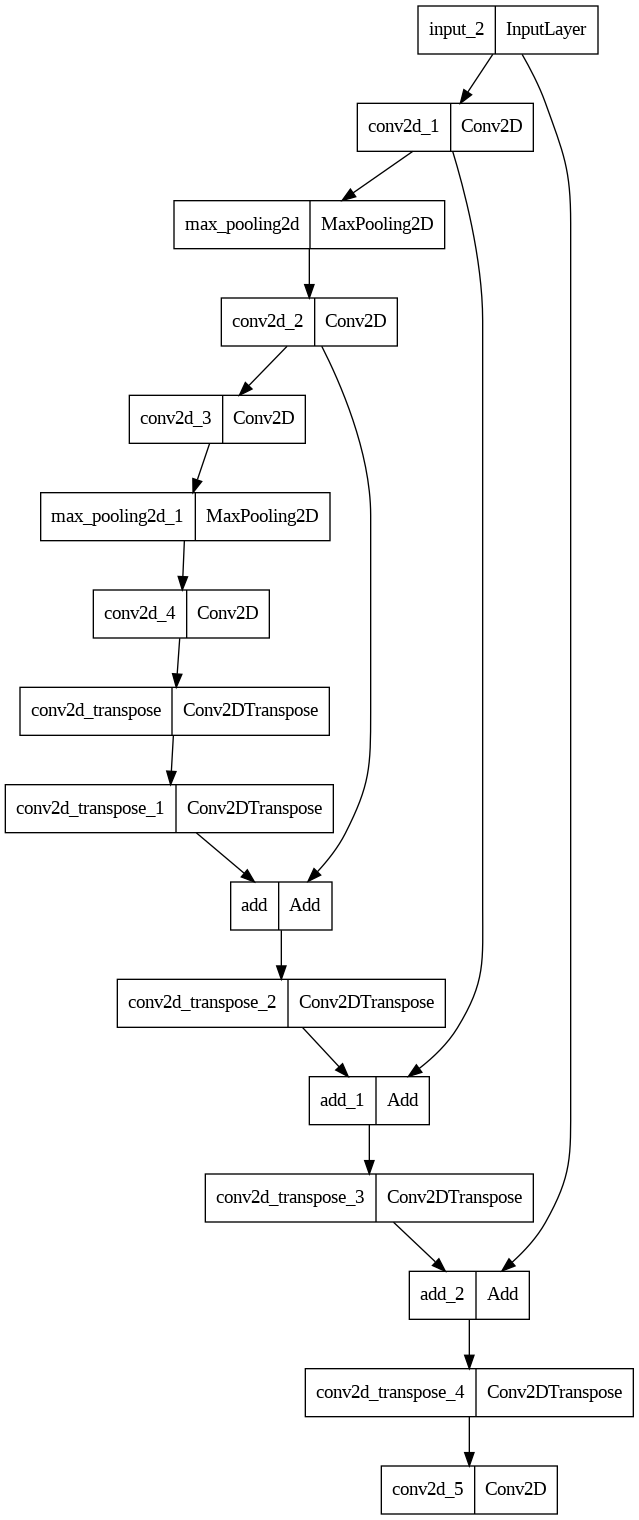

In [15]:
keras.utils.plot_model(demosaic)

##### train the model

In [16]:
demosaic.fit(train_dataset,
    epochs=1000,
    batch_size=32,
    shuffle=True,
    validation_data=test_dataset
)

Epoch 1/1000
15/15 [==============================] - 8s 59ms/step - loss: 0.1981 - val_loss: 0.1743
Epoch 2/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.1628 - val_loss: 0.1405
Epoch 3/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.1391 - val_loss: 0.1177
Epoch 4/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.1094 - val_loss: 0.0908
Epoch 5/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0844 - val_loss: 0.0663
Epoch 6/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0605 - val_loss: 0.0505
Epoch 7/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0488 - val_loss: 0.0443
Epoch 8/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0440 - val_loss: 0.0418
Epoch 9/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0418 - val_loss: 0.0404
Epoch 10/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0405 - val_lo

In [17]:
demosaic.save("demosaic")
!tar -czvf demosaic.tar.gz demosaic/
files.download('demosaic.tar.gz')

demosaic/
demosaic/fingerprint.pb
demosaic/assets/
demosaic/variables/
demosaic/variables/variables.index
demosaic/variables/variables.data-00000-of-00001
demosaic/saved_model.pb
demosaic/keras_metadata.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
dog=demosaic.predict(cfaSample.predict(im[21:22,:,:,:]))

1/1 [==============================] - 0s 379ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

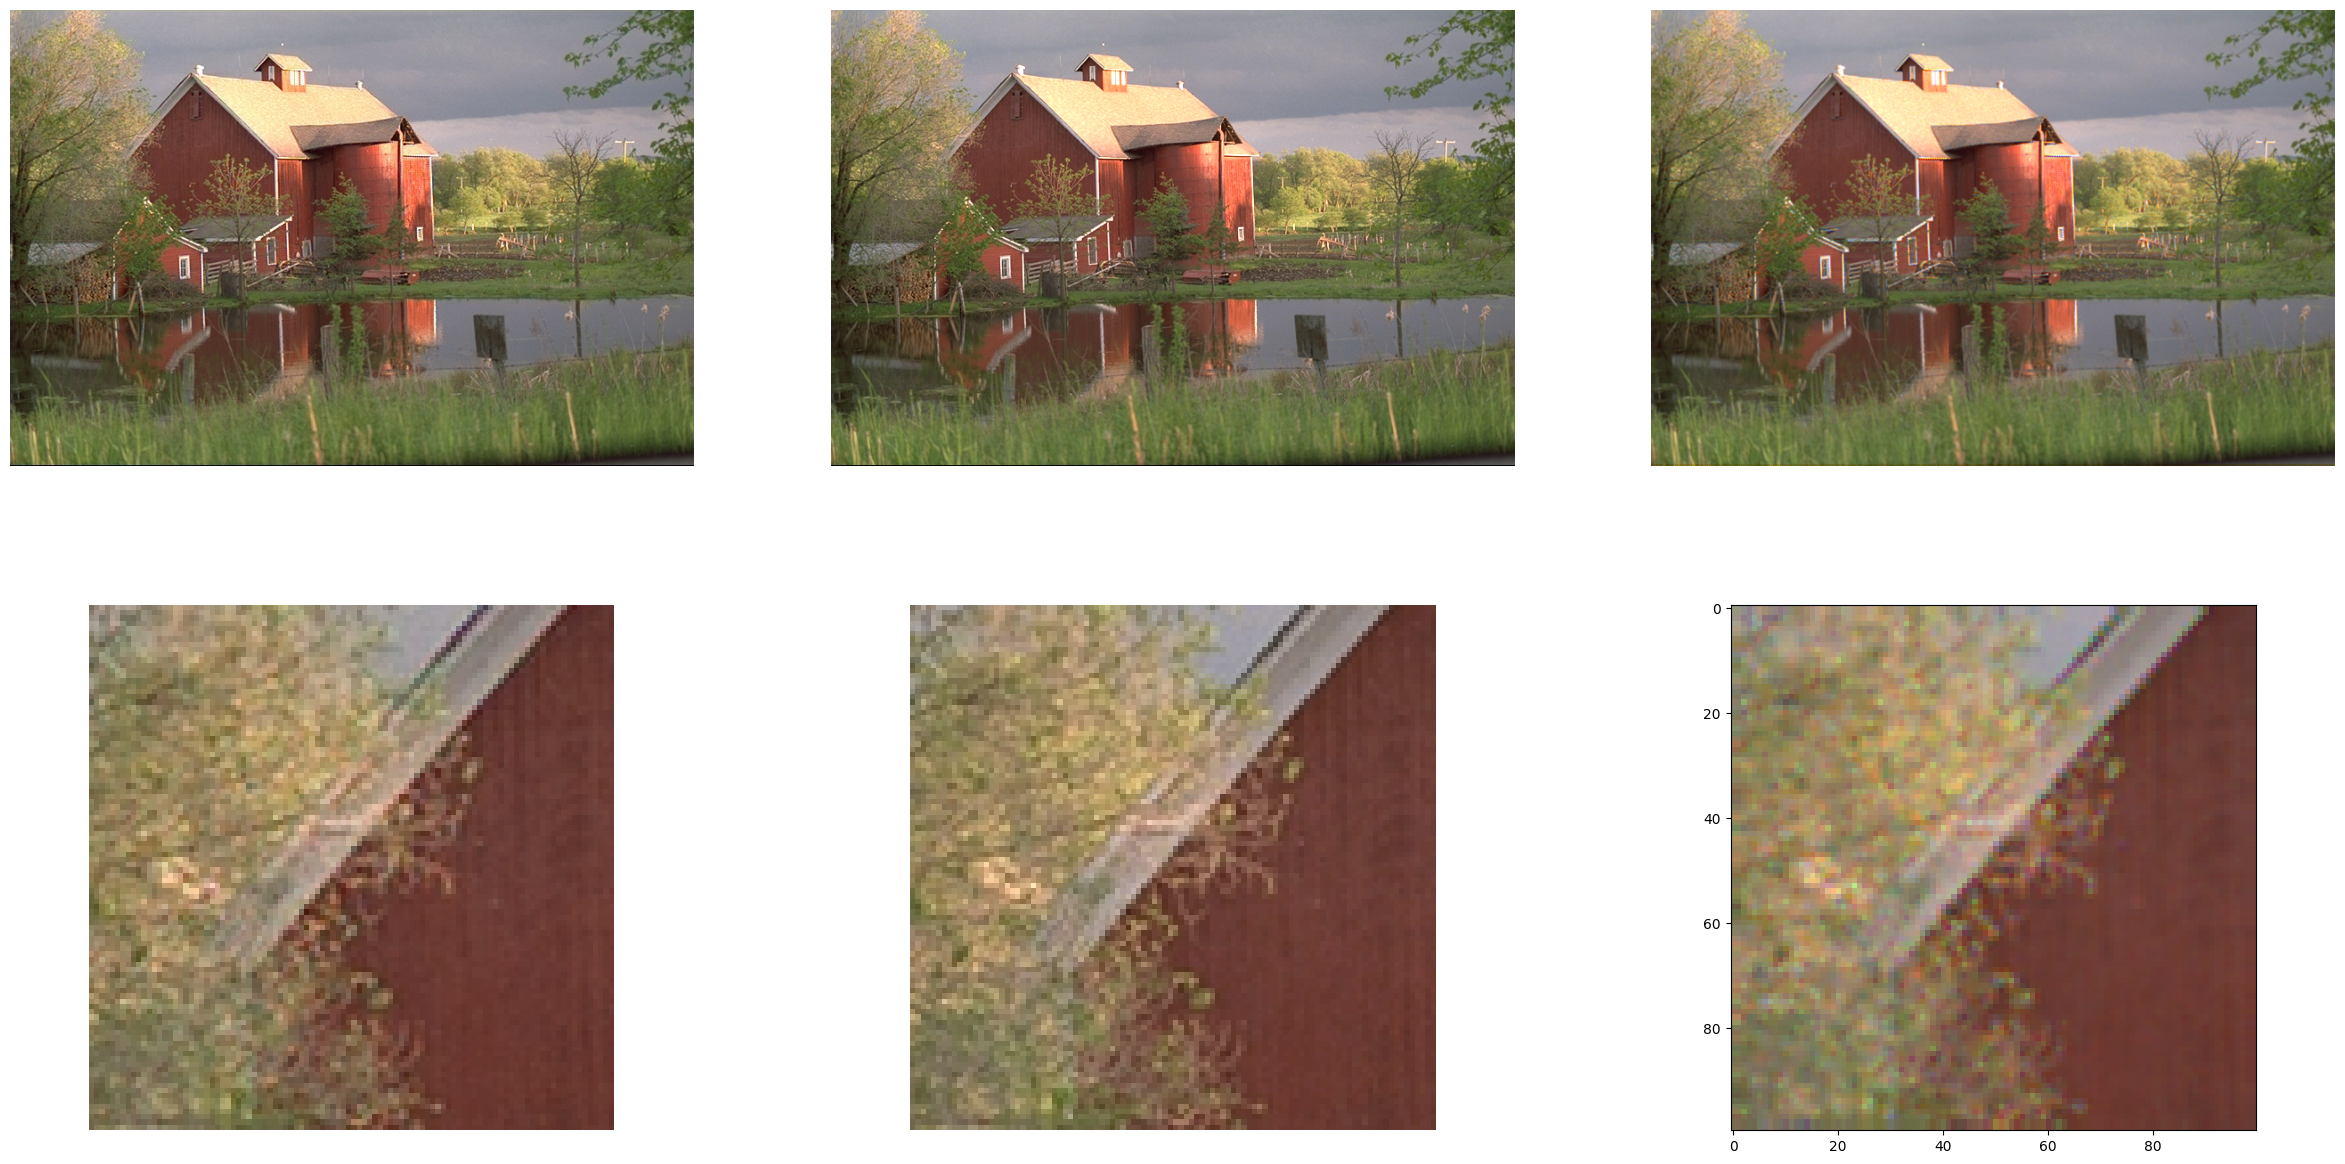

In [20]:
plt.figure(figsize=(30,15))
plt.subplot(2,3,1)
plt.imshow(dog[0,:,:,:])
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(im[21,:,:,:])
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[21,:,:,:]), cv2.COLOR_BayerGR2BGR))
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(dog[0,100:200,100:200,:])
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(im[21,100:200,100:200,:])
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[21,100:200,100:200,:]), cv2.COLOR_BayerGR2BGR))
plt.savefig('farmHouse.pdf')
files.download('farmHouse.pdf')

## loading trained model

In [7]:
!wget --no-check-certificate --content-disposition 'https://github.com/arizonaCameraLab/computationalImaging/raw/master/inverseProblems/demosaic.tar.gz'
!tar -xvf demosaic.tar.gz

--2023-09-05 20:08:11--  https://github.com/arizonaCameraLab/computationalImaging/raw/master/inverseProblems/demosaic.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arizonaCameraLab/computationalImaging/master/inverseProblems/demosaic.tar.gz [following]
--2023-09-05 20:08:11--  https://raw.githubusercontent.com/arizonaCameraLab/computationalImaging/master/inverseProblems/demosaic.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224142 (219K) [application/octet-stream]
Saving to: ‘demosaic.tar.gz’

demosaic.tar.gz     100%[===================>] 218.89K  --.-KB/s    in 0.02s   

2023

In [8]:
demosaic = keras.models.load_model('demosaic')

1/1 [==============================] - 0s 393ms/step


(-0.5, 767.5, 511.5, -0.5)

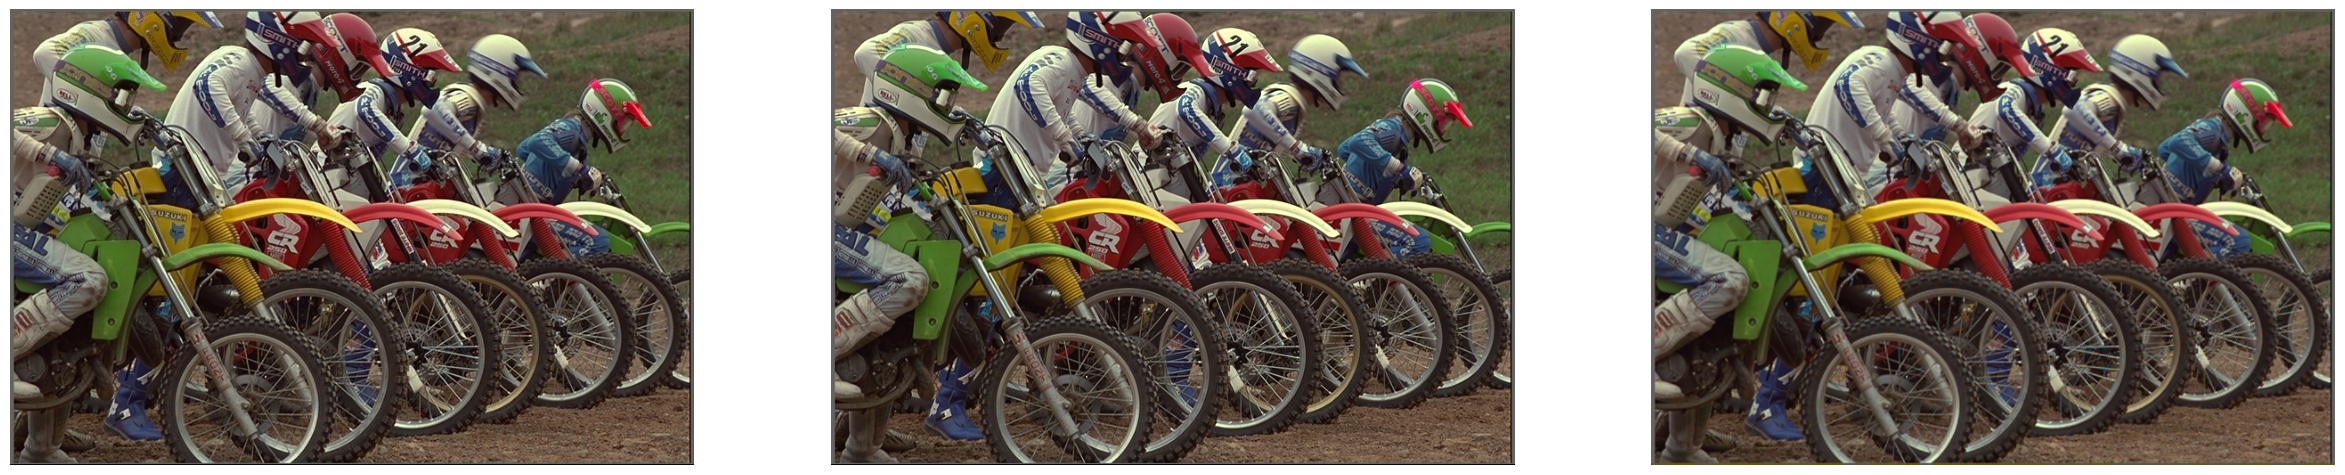

In [9]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(demosaic.predict(cfaSample.predict(im[4:5,:,:,:]))[0,:,:,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[4,:,:,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[4,:,:,:]), cv2.COLOR_BayerGR2BGR))
plt.axis('off')


### peformance metrics for the model

In [11]:
estimates=demosaic.predict(cfaSample.predict(im))

1/1 [==============================] - 2s 2s/step


In [12]:
pp=0
for pop in range(im.shape[0]):
  p=psnr(im[pop,:,:,:],np.float64(estimates[pop,:,:,:]))
  print("estimation psnr is ", p)
  pp=pp+p
print('the mean psnr is ', pp/np.float64(im.shape[0]))


estimation psnr is  34.59704467401076
estimation psnr is  37.078285810831275
estimation psnr is  38.1643622262163
estimation psnr is  37.91290795436778
estimation psnr is  34.08187306870715
estimation psnr is  35.794753312032654
estimation psnr is  38.697071960360795
estimation psnr is  30.848875173556603
estimation psnr is  38.8430637760472
estimation psnr is  39.01575181021836
estimation psnr is  36.45578124938713
estimation psnr is  39.55591624966228
estimation psnr is  32.01477907489563
estimation psnr is  34.09609531493379
estimation psnr is  36.75688687855715
estimation psnr is  39.13551649188159
estimation psnr is  38.37228051069585
estimation psnr is  34.391272480736134
estimation psnr is  35.619527645676236
estimation psnr is  37.005064767096776
estimation psnr is  35.722635448169854
estimation psnr is  35.521687720910165
estimation psnr is  37.72239463605019
estimation psnr is  32.67731725548673
the mean psnr is  36.25338106210369


In [24]:
pp=0
for pop in range(im.shape[0]):
  p=psnr(im[pop,:,:,:],np.float64(cv2.cvtColor(rgb2bayerGR2(im[pop,:,:,:]), cv2.COLOR_BayerGR2BGR)/255.))
  print("cv2 psnr is ", p)
  pp=pp+p
print('the mean psnr is ', pp/np.float64(im.shape[0]))

cv2 psnr is  25.82919773172801
cv2 psnr is  31.389371445252653
cv2 psnr is  32.210783460602705
cv2 psnr is  31.89658299429411
cv2 psnr is  26.27082379524768
cv2 psnr is  27.161525118045205
cv2 psnr is  31.702344107134866
cv2 psnr is  23.409959626748673
cv2 psnr is  31.092970114288697
cv2 psnr is  30.922100188530166
cv2 psnr is  28.545755737410886
cv2 psnr is  31.377174356350885
cv2 psnr is  23.71657034689133
cv2 psnr is  28.445350875806025
cv2 psnr is  30.22019317453791
cv2 psnr is  30.09169751806716
cv2 psnr is  31.917180099380957
cv2 psnr is  27.9149873568107
cv2 psnr is  28.248855668950057
cv2 psnr is  28.848611526073313
cv2 psnr is  28.03644914206968
cv2 psnr is  29.824746692442602
cv2 psnr is  32.644929210037716
cv2 psnr is  26.590573612958657
the mean psnr is  29.09619724581921


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

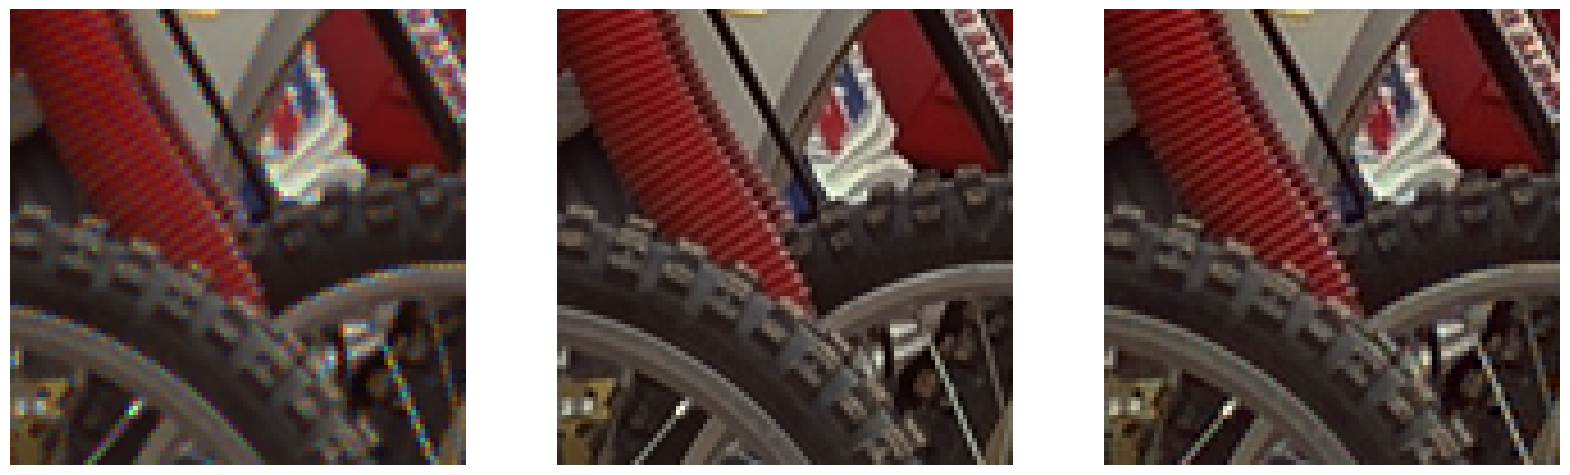

In [25]:
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[4,:,:,:]), cv2.COLOR_BayerGR2BGR)[250:350,350:450,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[4,250:350,350:450,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(estimates[4,250:350,350:450,:])
plt.axis('off')
plt.savefig('cycleDetail.pdf')
files.download('cycleDetail.pdf')